In [1]:

import pyart
import h5py
import numpy as np
import math as m
from scipy import ndimage
from time import time
import file_tools

"""
dualprf_cor
===========
Correct dual-PRF dealiasing errors

    correct_dualprf
    fold_circular
    instrument_parameters_odimh5
    local_cmean
    local_mean
    local_median
    local_valid
    _dualprf_error_unwrap
    _dummy_cols
    _get_prf_pars
    _get_prf_pars_odimh5
    _mask_diff_above
    _min_valid_mask
    _prf_factor_array
    _prf_hl_kernels
    _sign_array
    _vel_ref
    _vref_cmean_sc
"""

def correct_dualprf(radar, method_det, vel_field='velocity', 
                    kernel_det=np.ones((7,7)), min_valid_det=1, 
                    max_dev=1.0, two_step=True, method_cor=None, 
                    kernel_cor=None, min_valid_cor=1, new_field='velocity_cor',
                    replace=False, new_field_name='velocity_cor', 
                    new_field_lname='Dual-PRF outlier corrected velocity'):
    """
    Correction of dual-PRF outliers in radar velocity data. 
    Includes the corrected field in the input radar object. 
  
    Available reference statistics:
    'mean' : local mean velocity (Joe and May, 2003)
    'median' : local median velocity (Holleman and Beekhuis, 2003)
    'cmean_sc' : local circular mean velocity (PRF-scaled) (Altube et al., 2017)
    'cmean' : local circular mean velocity (Hengstebeck et al., 2018)
                

    Parameters
    ----------
    radar : Radar
        Py-ART radar structure
    method_det : str
        Detection method
    vel_field: str
        Input velocity field name (dual-PRF)
    kernel_det : array
        Neighbour kernel, 1/0 values (detection), if None a 7x7 ones array 
        is used, excluding the central value
    min_valid_det : int
        Minimum number of valid neighbours (detection)
    max_dev : float
        Maximum deviation threshold (detection)
    two_step : bool
        Whether to separate detection and correction stages
    method_cor : str or None
        Correction method, if None, method_det is used (except in the case of 
        'cmean_sc', for which 'cmean' is used by default, due to error 
        propagation issues when PRF scaling)
    kernel_cor : array
        Neighbour kernel 1/0 values (correction), if None, kernel_det is used
    min_valid_cor : int
        Minimum number of valid neighbours (correction)
    new_field : str
        Output (corrected) velocity field name
    replace : bool
        Whether to replace input field
    new_field_name : str
        Output (corrected) velocity field standard name
    new_field_lname : str
        Output (corrected) velocity field long name

    """
    timer = time()
    vcorr = radar.fields[vel_field]['data'].copy()
    for sw, sweep_slice in enumerate(radar.iter_slice()):
        print('sweep', sw, 'elevation:', radar.fixed_angle['data'][sw])
        # Dual-PRF parameters
        v_ny, prf_h, prf_factor, prf_flag = file_tools.get_prf_pars(radar, sw)
        if prf_flag is None:
            print('  Skipping sweep - not dual-PRF')
            continue
        
        prf_factor_sw = file_tools.prf_factor_array(radar, sw)

        # primary velocities
        vp_sw = v_ny/prf_factor
        print(vp_sw)
        #extract velocity sweep
        v_sw = np.ma.masked_invalid(radar.fields[vel_field]['data'][sweep_slice])

        # ERROR DETECTION
        # Reference velocities at each gate
        vref_det = _vel_ref(data_ma=v_sw, method=method_det, 
                              kernel=kernel_det, v_ny=v_ny, 
                              mask=None,
                              prf_factor_arr=prf_factor_sw, 
                              min_valid=min_valid_det)
        
        # Calculate difference in phase space
        ph_obs = v_sw*(m.pi/v_ny)
        ph_ref = vref_det*(m.pi/v_ny)
        
        ph_diff = ph_obs - ph_ref
        diff_ma = (v_ny/m.pi)*np.ma.arctan2(np.ma.sin(ph_diff), np.ma.cos(ph_diff))


        # Outlier mask
        err_mask = _mask_diff_above(diff_ma=diff_ma, th_ma=max_dev*vp_sw)

        if two_step:
            
            vref_cor = _vel_ref(data_ma=v_sw, method='cmean', 
                                  kernel=kernel_cor, v_ny=v_ny, 
                                  mask=err_mask, 
                                  prf_factor_arr=prf_factor_sw, 
                                  min_valid=min_valid_cor)

        else:
            vref_cor = vref_det

        # ERROR CORRECTION
        # Unwrap number and corrected velocity field
        uwp = _dualprf_error_unwrap(data_ma=v_sw, ref_ma=vref_cor, 
                                   err_mask=err_mask, pvel_arr=vp_sw, 
                                   prf_arr=prf_factor_sw)

        # Correct velocity field
        vc = v_sw + 2 * uwp * vp_sw
        
        # Fold velocity values into Nyquist interval
        vcorr[sweep_slice] = fold_circular(data_ma=vc, mod=v_ny)

    # ADD CORRECTED VELOCITY FIELD
    file_tools.add_vcor_field(radar, field_i=vel_field, field_o=new_field, 
                        data=vcorr, std_name=None,
                        description='Correction of dual-PRF applied using technique developed by Hengstebeck et al. (2018) doi:10.1175/JTECH-D-16-0230.1. Implementation by Servei Meteorològic de Catalunya at https://github.com/meteocat/vcor_dual_prf',
                        long_name=new_field_lname, replace=replace)
    
    print('final', time()-timer)
    return radar


def fold_circular(data_ma, mod):
    """
    Values outside the specified interval are folded back into 
    the interval.

    Parameters
    ----------
    data_ma : masked array
        Data
    mod: float
        Interval (module)

    Returns
    -------
    ma_fold :  masked array
        Folded data
    """

    # Phase space
    ph = data_ma*m.pi/mod
    ph_fold = np.ma.arctan2(np.ma.sin(ph), np.ma.cos(ph))
    
    # Back to original variable
    ma_fold = ph_fold*mod/m.pi

    return ma_fold


def local_cmean(data_ma, kernel):
    """
    Calculates local circular mean of a masked array;
    edges are wrapped in azimuth and padded with NA in range.
    
    Parameters
    ----------
    data_ma : masked array
        Data
    kernel : array
        Local neighbour kernel, 1/0 values

    Returns
    -------
    cmean_ma : masked array
        Local circular mean of the data.
    """

    # Arrays of trigonometric variables
    cos_ma = np.ma.cos(data_ma)
    sin_ma = np.ma.sin(data_ma)

    # Arrays with local means of trigonometric variables
    cos_avg = local_mean(cos_ma, kernel)
    sin_avg = local_mean(sin_ma, kernel)

    # Local circular mean
    cmean_ma = np.ma.arctan2(sin_avg, cos_avg)

    return cmean_ma


def local_mean(data_ma, kernel):
    """
    Calculates local mean of a masked array;
    edges are wrapped in azimuth and padded with NA in range.
    
    Parameters
    ----------
    data_ma : masked array
        Data
    kernel : array
        Local neighbour kernel, 1/0 values

    Returns
    -------
    avg_ma : masked array
        Local mean of the data.
    """

    data = data_ma.data
    mask = data_ma.mask

    # Local number of valid neighbours
    valid_num = local_valid(mask, kernel=kernel)
    dummy_data = data*(~mask)

    # Add dummy columns for wrapping
    col_num, conv_arr = _dummy_cols(dummy_data, kernel, value=0)

    # Sum local values
    sum_arr = ndimage.convolve(conv_arr, weights=kernel, mode='wrap')

    # Remove added columns
    sum_arr = sum_arr[:, : (sum_arr.shape[1] - col_num)]

    # Calculate average
    avg_ma = np.ma.array(data=sum_arr/valid_num, mask=mask)

    return avg_ma


def local_median(data_ma, kernel):
    """
    Calculates local median of a masked array;
    edges are wrapped in azimuth and padded with NA in range.

    Parameters
    ----------
    data_ma : masked array
        Data
    kernel : array
        Local neighbour kernel, 1/0 values

    Returns
    -------
    med_ma : masked array
        Local median of the data
    """

    data = data_ma.data
    mask = data_ma.mask

    dummy_data = np.where((~mask), data, np.nan)

    # Add dummy columns for wrapping
    # NA values (masked and dummy) need to be 'nan' for generic filter
    col_num, conv_arr = _dummy_cols(dummy_data, kernel, value=None)

    # Median filter
    med_arr = ndimage.generic_filter(conv_arr, np.nanmedian, 
                                     footprint=kernel, mode='wrap')

    # Remove added columns
    med_arr = med_arr[:, : (med_arr.shape[1] - col_num)]
    med_ma = np.ma.array(data=med_arr, mask=mask)

    return med_ma


def local_valid(mask, kernel=np.ones((3, 3))):
    """
    Calculate number of local neighbours with a valid value

    Parameters
    ----------
    mask : numpy array (2D)
        Boolean label (1/0) indicating non NA gate values.
    kernel : numpy array (2D)
        Convolution kernel indicating which local neighbours to consider

    Returns
    -------
    valid : numpy array (2D)  of int
        Number of valid neighbours for each gate.
    """

    # Add dummy columns to mask
    mask = (~mask).astype(int)
    ncols, mask_tmp = _dummy_cols(mask, kernel, value=0)

    # Convolve with kernel to calculate number of valid neighbours
    valid_tmp = ndimage.convolve(mask_tmp, kernel, mode='wrap')

    # Remove added values
    valid = valid_tmp[:, : (valid_tmp.shape[1] - ncols)]

    return valid.astype(int)

def _dualprf_error_unwrap(data_ma, ref_ma, err_mask, pvel_arr, prf_arr):
    """
    Finds the correction factor that minimises the difference between
    the gate velocity and the reference velocity

    Parameters
    ----------
    data_ma : masked array
        Data
    ref_ma : masked array
        Reference data
    err_mask : bool array
        Mask for the identified outliers
    pvel_arr : array
        Primary (high/low PRF) velocity for each gate
    prf_arr : array
        PRF (high/low) of each gate

     Returns
     -------
     nuw : int array
         Unwrap number (correction factor) for each gate
     """

    # Convert non-outliers to zero
    ma_out = data_ma * err_mask.astype(int)
    th_arr_out = pvel_arr * err_mask.astype(int)
    ref_out = ref_ma * err_mask.astype(int)

    # Primary velocity and prf factor of low PRF gates
    prf_factor = np.unique(np.min(prf_arr))[0]
    th_l = th_arr_out.copy()
    th_l[prf_arr == prf_factor] = 0

    dev = np.ma.abs(ma_out - ref_out)
    nuw = np.zeros(ma_out.shape)

    # Loop for possible correction factors
    for ni in range(-prf_factor, (prf_factor + 1)):

        # New velocity values for identified outliers
        if abs(ni) == prf_factor:
            v_corr_tmp = ma_out + 2 * ni * th_l
        else:
            v_corr_tmp = ma_out + 2 * ni * th_arr_out

        # New deviation for new velocity values
        dev_tmp = np.ma.abs(v_corr_tmp - ref_out)
        # Compare with previous deviation
        delta = dev - dev_tmp

        # Update unwrap number when deviation has decreased
        nuw[delta > 0] = ni
        # Update corrected velocity and deviation
        v_corr = ma_out + 2 * nuw * th_arr_out
        dev = np.ma.abs(v_corr - ref_out)

    return nuw.astype(int)


def _dummy_cols(data, kernel=np.ones((3, 3)), value=None):
    """
    Add dummy (e.g. NA/NAN) values in range so that 'wrap' property can
    be applied in convolution operations.

    Parameters
    ----------
    data : array
        Data
    kernel : array
        Neighbour kernel 1/0 values
    value : float or None
        Value set in dummy columns

    Returns
    -------
    col_num : int
        Number of columns added.
    data_out : array
        Data with added dummy columns.
    """

    
    c = (np.asarray(kernel.shape) - 1) / 2  # 'center' of kernel
    col_num = int(np.ceil(c[1]))

    cols = np.zeros((data.shape[0], col_num))

    if value is None:
        cols[:] = np.NAN
    else:
        cols[:] = value

    # Add dummy columns
    data_out = np.hstack((data, cols))

    return col_num, data_out      
    
def _mask_diff_above(diff_ma, th_ma):
    """
    Creates a mask of the values which differ from a reference more
    than a specified threshold

    Parameters
    ----------
    data_ma : masked array
        Data
    ref_ma : masked array
        Reference data
    th_ma :  masked array
        Threshold values

     Returns
     -------
     mask : numpy bool mask
         Masked above threshold
         
     """

    mask = np.zeros(diff_ma.shape)
    
    mask[np.ma.abs(diff_ma) > th_ma] = 1
    mask[diff_ma.mask] = 0

    return mask.astype(bool)


def _min_valid_mask(mask, kernel, min_th=1):
    """
    Mask for gates that do not have a minimum number of valid neighbours
    
    """
    
    valid_num_arr = local_valid(mask, kernel)
    nmin_mask = np.zeros(mask.shape)
    nmin_mask[valid_num_arr < min_th] = 1

    return nmin_mask.astype(bool)

def _prf_hl_kernels(kernel):
    """
    Separates the kernel into high-PRF and low-PRF gate kernels, 
    assuming always that the central gate is low-PRF

    Parameters
    ----------
    kernel : array
       Neighbour kernel 1/0 values

    Returns
    -------
    k_h, k_l : array
        Neighbour kernel (1/0 values) for high-PRF (h) or low-PRF (l)
        
    """

    k_h, k_l = np.zeros(kernel.shape), np.zeros(kernel.shape)
   
    rem = int((kernel.shape[0] - 1) / 2 % 2)
    k_h[abs(rem - 1)::2] = kernel[abs(rem - 1)::2]
    k_l[rem::2] = kernel[rem::2]

    return k_h, k_l


def _sign_array(prf_factor_arr):
    """
     Builds a signature array based on the PRF at the scanned gate 
     (-1 for high-PRF, +1 for low PRF)

     Parameters
     ----------
     prf_factor_arr : array
         PRF-factor for each gate

     Returns
     -------
     sign_arr : array
         Neighbour kernel (-1/1 values) for high-PRF (h) or low-PRF (l)
     """

    sign_arr = np.ones(prf_factor_arr.shape)
    sign_arr[np.where(prf_factor_arr == np.min(prf_factor_arr))] = -1

    return sign_arr


def _vel_ref(data_ma, method='mean', kernel=np.ones((5, 5)), v_ny=None, 
            mask=None, prf_factor_arr=None, min_valid=1):
    """
    Estimate reference velocity using different local statistics:
    'mean' : local mean velocity (Joe and May, 2003)
    'median' : local median velocity (Holleman and Beekhuis, 2003)
    'cmean_sc' : local circular mean velocity (Altube et al., 2017)
    'cmean' : local circular mean velocity (Hengstebeck et al., 2018)

    Parameters
    ----------
    data_ma : masked array
        Data
    kernel : array
        Neighbour kernel (1/0 values)
    v_ny : float
        Nyquist velocity
    mask : bool array
        User-defined mask
    prf_factor_arr : array (1D)
        Dual-PRF factor of each ray (N+1: low PRF, N: high-PRF)
    min_valid : int
        Minimum number of valid neighbours

     Returns
     -------
     v_ref : array
         Reference velocity for each gate
     """
    
    if mask is None:
        mask = data_ma.mask
    else:
        mask= np.ma.mask_or(data_ma.mask, mask)

    vel_ma = np.ma.array(data=data_ma.data, mask=mask)


    stat_fn = {'mean': local_mean, 'median': local_median,
                'cmean': local_cmean}

    # Mask gates which do not have a minimum number of neighbours
    nmin_mask = _min_valid_mask(data_ma.mask, kernel=kernel,
                                    min_th=min_valid)
    new_mask = np.ma.mask_or(data_ma.mask, nmin_mask)

    ph_arr = vel_ma * (np.pi / v_ny)
    v_ref = (v_ny / np.pi) * stat_fn[method](ph_arr, kernel=kernel)

    # print('v_ny', v_ny)
    # print('kernel', kernel)
    # print('ph_arr', ph_arr.data[0,:])
    # print('v_ref', v_ref)
    # print('method', stat_fn[method])
    # print('stat method', stat_fn[method](ph_arr, kernel=kernel))

    # from matplotlib import pyplot as plt
    # plt.pcolor(v_ref)

    v_ref = np.ma.array(data=v_ref.data, mask=new_mask)
        
    v_ref = fold_circular(v_ref, mod=v_ny)

    return v_ref

In [2]:
import pyart
from copy import deepcopy
from matplotlib import pyplot as plt
from file_tools import instrument_parameters_pyart

new_odim_mixed = '/g/data/kl02/jss548/aura/testing_files/dualprf/66_20231210_032500.pvol.h5'
radar = pyart.aux_io.read_odim_h5(new_odim_mixed, file_field_names=True)
radar = instrument_parameters_pyart(radar=radar, odim_file=new_odim_mixed)




In [3]:
radar_test = deepcopy(radar)
radar_test = correct_dualprf(radar_test, two_step=True,
                                method_det='cmean', kernel_det=np.ones((11, 11)),
                                method_cor='cmean', kernel_cor=np.ones((5, 5)),
                                vel_field='VRADH', new_field='velocity_dprf')

sweep 0 elevation: 90.0
  Skipping sweep - not dual-PRF
sweep 1 elevation: 32.0
  Skipping sweep - not dual-PRF
sweep 2 elevation: 23.0
  Skipping sweep - not dual-PRF
sweep 3 elevation: 17.0
  Skipping sweep - not dual-PRF
sweep 4 elevation: 13.0
  Skipping sweep - not dual-PRF
sweep 5 elevation: 10.0
  Skipping sweep - not dual-PRF
sweep 6 elevation: 7.8
  Skipping sweep - not dual-PRF
sweep 7 elevation: 6.0
  Skipping sweep - not dual-PRF
sweep 8 elevation: 4.7
  Skipping sweep - not dual-PRF
sweep 9 elevation: 3.5
  Skipping sweep - not dual-PRF
sweep 10 elevation: 2.4
  Skipping sweep - not dual-PRF
sweep 11 elevation: 1.4
23.6025
sweep 12 elevation: 0.8
21.6356
sweep 13 elevation: 0.5
15.735
final 2.4487318992614746


(-100.0, 0.0)

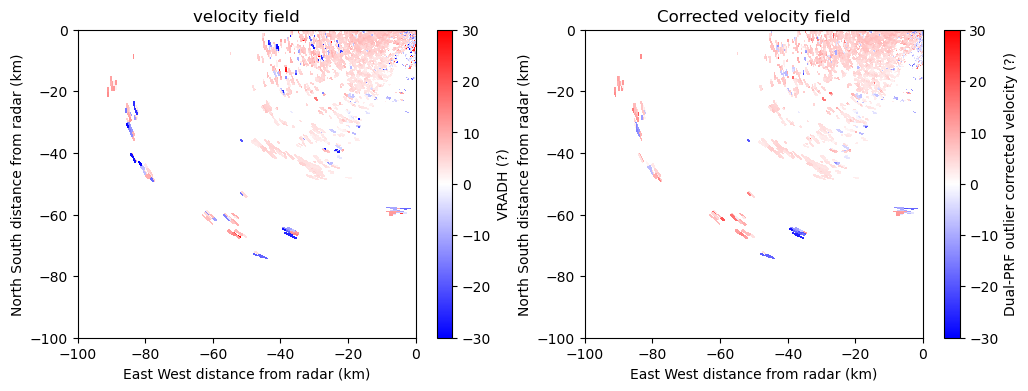

In [4]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12,4))
disp = pyart.graph.RadarDisplay(radar_test)
ylim = (-100, 0)
xlim = (-100, 0)
sweep_idx = 13
disp.plot_ppi('VRADH', sweep_idx, ax=ax1, title='velocity field', vmin=-30, vmax=30, cmap='bwr')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
disp.plot_ppi('velocity_dprf', sweep_idx, ax=ax2, title='Corrected velocity field', vmin=-30, vmax=30, cmap='bwr')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)